In [1]:
import pandas as pd
from nilearn.glm.first_level import first_level_from_bids, make_first_level_design_matrix
from nilearn.glm.first_level.design_matrix import _convolve_regressors
import yaml, os
import numpy as np
import nibabel as nib
from scipy.stats import ttest_1samp, norm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from bids import BIDSLayout
from tqdm.auto import tqdm
from fmri_encoder.lazy import default_process_and_cv_encode, default_processing, default_cv_encoder, default_encoder
from fmri_encoder.data import fetch_masker
from fmri_encoder import plotting
from fmri_encoder.plotting import pretty_plot
import seaborn as sns
import plotly.express as px
from IPython.display import clear_output

from importlib import reload
import fast_ridge
reload(fast_ridge)
from fast_ridge import *

from scipy.stats import spearmanr
from nilearn.glm import fdr_threshold
from scipy.stats import norm
pd.set_option('display.max_columns', None)

import plotly.io as pio
import plotly.express as px
import seaborn as sns
pio.templates.default = "seaborn"
pio.renderers.default = "browser"
pio.templates[pio.templates.default].layout.xaxis.exponentformat = "power"
pio.templates[pio.templates.default].layout.yaxis.exponentformat = "power"
pio.templates[pio.templates.default].layout.margin = dict(t=20, b=0, l=0, r=0)
# pio.templates[pio.templates.default].layout.colorway = sns.color_palette("tab20").as_hex()
pio.templates[pio.templates.default].layout.colorway = sns.color_palette().as_hex()
# pio.templates[pio.templates.default].layout.legend.orientation = "h"
# pio.templates[pio.templates.default].layout.legend.yanchor = "bottom"
# pio.templates[pio.templates.default].layout.legend.y = 1.02
# pio.templates[pio.templates.default].layout.legend.xanchor = "center"
# pio.templates[pio.templates.default].layout.legend.x = 0.5

lang = "EN"
subj = "meanEN"
derivatives = "derivatives"
model = "LASER"
embedding = "sentence"
encoding_method = "hrf"
def masker_path():
    return f"fmri_encoder/maskers/{subj}_masker"
def save_path():
    return f"fmri_encoder/outputs/{subj}_{encoding_method}{'_' + model if model != '' else ''}_scores.npz"

# Loading embeddings

In [2]:
path = "annotation/%LANG%/lpp%LANG%_%EMBEDDING%_embeddings_%MODEL%"
model_path = path.replace("%LANG%", lang).replace("%MODEL%", model).replace("%EMBEDDING%", embedding)
if os.path.exists(model_path + ".parquet"):
    df = pd.read_parquet(model_path + ".parquet")
else:
    df = pd.read_csv(model_path + ".csv", index_col=0).dropna()
    df_parsed = df.apply(lambda s: pd.Series(s.strip("[]").split()).astype(float))
    df_parsed.columns = [f"{model}_{i}" for i in df_parsed.columns]
    df_parsed["word"] = df.word
    df_parsed.to_parquet(model_path + ".parquet")
    df = df_parsed
if embedding == "word":
    df["word_index"] = df.index

# Loading fMRI and events

In [3]:
_, imgs, events, _ = first_level_from_bids(derivatives, t_r=2, derivatives_folder="", task_label=f"lpp{lang}", sub_labels=[subj])
imgs = imgs[0]
events = events[0]
if model != "":
    if embedding == "word":
        events = [e.merge(df, how="left", on=["word", "word_index"]) for e in events]
    else:
        events = [e.merge(df, how="left", on=["section", "time"]) for e in events]

In [4]:
features = ["intensity", "logfreq", "wordrate"]
if model != "":
    features.extend([col for col in events[0] if model in col])
X = [e[features].fillna(0).to_numpy() for e in events]
offsets = [e.time.to_numpy() for e in events]
if "duration" in df:
    durations = [e.duration.fillna(0).to_numpy() for e in events]
else:
    durations = [np.zeros(len(e)) for e in events]
Y = imgs

In [ ]:
processed_data = default_processing(
    X[:3],
    offsets[:3],
    durations[:3],
    2,
    Y[:3],
    masker_path=masker_path(),
    encoding_method=encoding_method,
)
Xs = processed_data["X"]
Ys = processed_data["Y"]
alphas = np.logspace(-8, 8, 10)
clear_output()

In [ ]:
processed_data = default_processing(
    X,
    offsets,
    2,
    Y,
    masker_path=masker_path(),
    encoding_method=encoding_method,
)
Xs = processed_data["X"]
Ys = processed_data["Y"]
alphas = np.logspace(-8, 8, 10)
clear_output()

In [ ]:
output = fast_ridge(Xs, Ys, alphas)

In [ ]:
metric = "r2"
values = output[metric]
masker = fetch_masker(masker_path(), None)
plot_name = None
if len(np.unique(values)) == 1:
    values[0] = values[1] + 1
if metric == "alpha":
    values = np.log10(values)
vmax = np.max(values)
imgs = [masker.inverse_transform(values)]
pretty_plot(
    imgs,
    None,
    None,
    [""],
    ref_img=None,
    vmax=[vmax],
    cmap="cold_hot",
    hemispheres=["left", "right"],
    views=["lateral", "medial"],
    colorbar=True,
    categorical_values=None,
    inflated=False,
    saving_folder="fmri_encoder/",
    format_figure="png",
    dpi=300,
    plot_name=plot_name,
    row_size_factor=8,  # you can play with these arguments to modify the shape of the brain vertically
    column_size_factor=12,  # you can play with these arguments to modify the shape of the brain horizontally
    overlapping=4,
)

# Inter-subject

In [33]:
layout = BIDSLayout("derivatives", validate=False, derivatives=True)
lang_plot = "FR"
subjects = layout.get_subjects(task="lpp" + lang_plot)

In [41]:
layout = BIDSLayout("derivatives", validate=False, derivatives=True)
lang_plot = "EN"
subjects = layout.get_subjects(task="lpp" + lang_plot)

In [47]:
layout = BIDSLayout("derivatives", validate=False, derivatives=True)
lang_plot = "CN"
subjects = layout.get_subjects(task="lpp" + lang_plot)

In [2]:
layout = BIDSLayout("derivatives", validate=False, derivatives=True)
lang_plot = ""
subjects = layout.get_subjects()

## Metric

In [7]:
metric = "r"
model = "LASER"
encoding_method = "hrf"
symmetric_cbar = False

In [8]:
imgs, affine, errors = [], None, []
for subj in tqdm(subjects):
    try:
        output_dict = dict(np.load(save_path(), allow_pickle=True))
        masker = fetch_masker(masker_path(), None)
        scores = output_dict[metric]
        if metric == "r2":
            scores = scores.clip(0, 1)
        img = masker.inverse_transform(scores)
        imgs.append(img.get_fdata())
        if affine is None:
            affine = masker.mask_img.affine
    except Exception as e:
        errors.append(f"{subj}: {e}")
n_subj = len(imgs)
imgs = np.stack(imgs)
pvalues = np.nan_to_num(ttest_1samp(imgs, popmean=0, axis=0).pvalue, nan=1)
zscores = norm.ppf(1 - pvalues)
thresh = fdr_threshold(zscores.reshape(-1), 5e-2)
# signif = fdrcorrection(pvalues.reshape(-1))[0].reshape(pvalues.shape)print(errors)

signif = zscores > thresh
imgs = imgs.mean(axis=0)
clear_output()
print(f"Number of subjects: {n_subj}, z-score threshold: {thresh}, {len(errors)} errors")

Number of subjects: 28, z-score threshold: 2.0703764732646084, 0 errors


In [9]:
plot_name = f"{encoding_method}_{metric}_mean{'_' + model if model != '' else ''}"
if lang_plot != "":
    plot_name += f"_{lang_plot}"
vmax = np.abs(imgs).max()
imgs_plot = [nib.Nifti1Image(imgs, affine)]

In [36]:
plot_name = f"{encoding_method}_{metric}_mean{'_' + model if model != '' else ''}_fdr"
if lang_plot != "":
    plot_name += f"_{lang_plot}"
vmax = np.abs(imgs[signif]).max()
imgs_signif = imgs.copy()
imgs_signif[~signif] = np.nan
imgs_plot = [nib.Nifti1Image(imgs_signif, affine)]

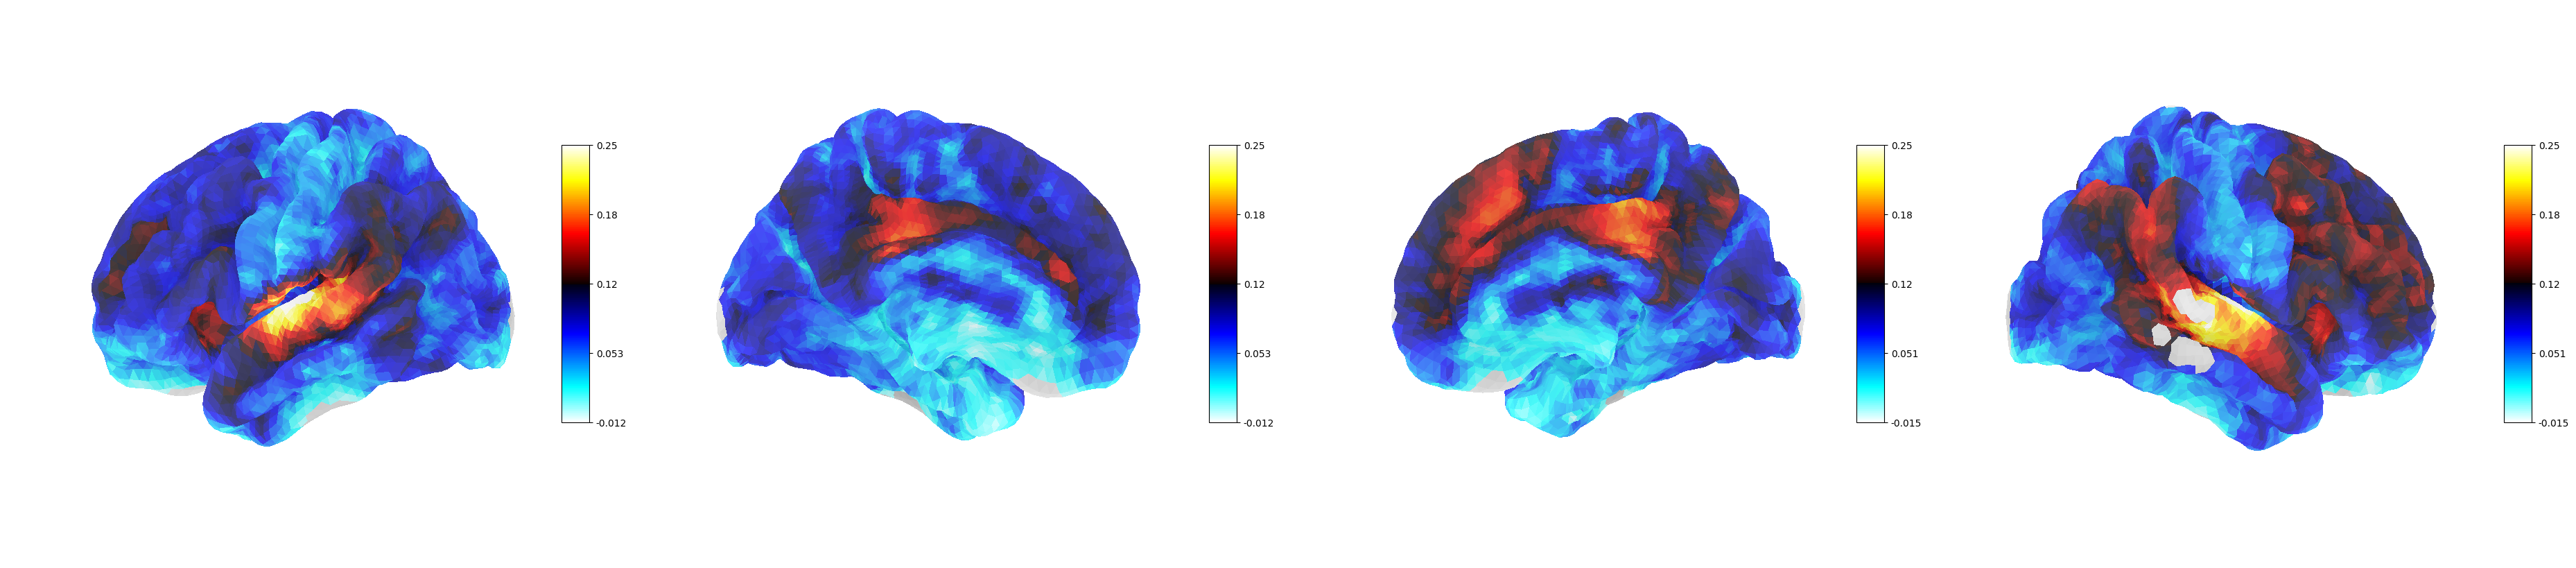

In [11]:
pretty_plot(
    imgs_plot, 
    None,
    None,
    [""],
    ref_img=None,
    vmax=[vmax], 
    cmap='cold_hot',
    hemispheres=['left', 'right'],
    views=['lateral', 'medial'],
    colorbar=True,
    symmetric_cbar=symmetric_cbar,
    categorical_values=None, 
    inflated=False, 
    saving_folder='fmri_encoder/', 
    format_figure='png', 
    dpi=300, 
    plot_name=plot_name,
    row_size_factor=8,          # you can play with these arguments to modify the shape of the brain vertically
    column_size_factor=12,      # you can play with these arguments to modify the shape of the brain horizontally
    overlapping=4,
)

## $\Delta R$

In [18]:
metric = "r"
m = "LASER"
encoding_method = "hrf"
symmetric_cbar = True

In [34]:
metric = "r"
m = "sBERT"
encoding_method = "hrf"
symmetric_cbar = True

In [48]:
assert m != ""
imgs, affine, errors = [], None, []
for subj in tqdm(subjects):
    model = m
    try:
        output_dict_glove = dict(np.load(save_path(), allow_pickle=True))
        model = ""
        output_dict = dict(np.load(save_path(), allow_pickle=True))
        masker = fetch_masker(masker_path(), None)
        scores = output_dict[metric]
        scores_glove = output_dict_glove[metric]
        img = masker.inverse_transform(scores)
        img_glove = masker.inverse_transform(scores_glove)
        imgs.append(img_glove.get_fdata() - img.get_fdata())
        if affine is None:
            affine = masker.mask_img.affine
    except Exception as e:
        errors.append(f"{subj}: {e}")
n_subj = len(imgs)
if n_subj > 1:
    imgs = np.stack(imgs)
    pvalues = np.nan_to_num(ttest_1samp(imgs, popmean=0, axis=0).pvalue, nan=1)
    zscores = norm.ppf(1 - pvalues)
    thresh = fdr_threshold(zscores.reshape(-1), 5e-2)
    # signif = fdrcorrection(pvalues.reshape(-1))[0].reshape(pvalues.shape)
    signif = zscores > thresh
    imgs = imgs.mean(axis=0)
else:
    imgs = imgs[0]
    thresh = None
clear_output()
print(f"Number of subjects: {n_subj}, z-score threshold: {thresh}, {len(errors)} errors")

Number of subjects: 35, z-score threshold: 2.9632563227581077, 0 errors


In [ ]:
pd.Series(np.log10(pvalues.reshape(-1))).hist(bins=100)

In [49]:
plot_name = f"{encoding_method}_mean_delta_{metric}_{model}"
if lang_plot != "":
    plot_name += f"_{lang_plot}"
vmax = np.abs(imgs).max()
imgs_plot = [nib.Nifti1Image(imgs, affine)]

In [92]:
plot_name = f"{encoding_method}_mean_delta_{metric}_{model}_fdr"
if lang_plot != "":
    plot_name += f"_{lang_plot}"
vmax = np.abs(imgs[signif]).max()
imgs_signif = imgs.copy()
imgs_signif[~signif] = np.nan
imgs_plot = [nib.Nifti1Image(imgs_signif, affine)]

In [50]:
vmax = 0.16

In [ ]:
plot_name = None

In [51]:
lang_plot

'CN'

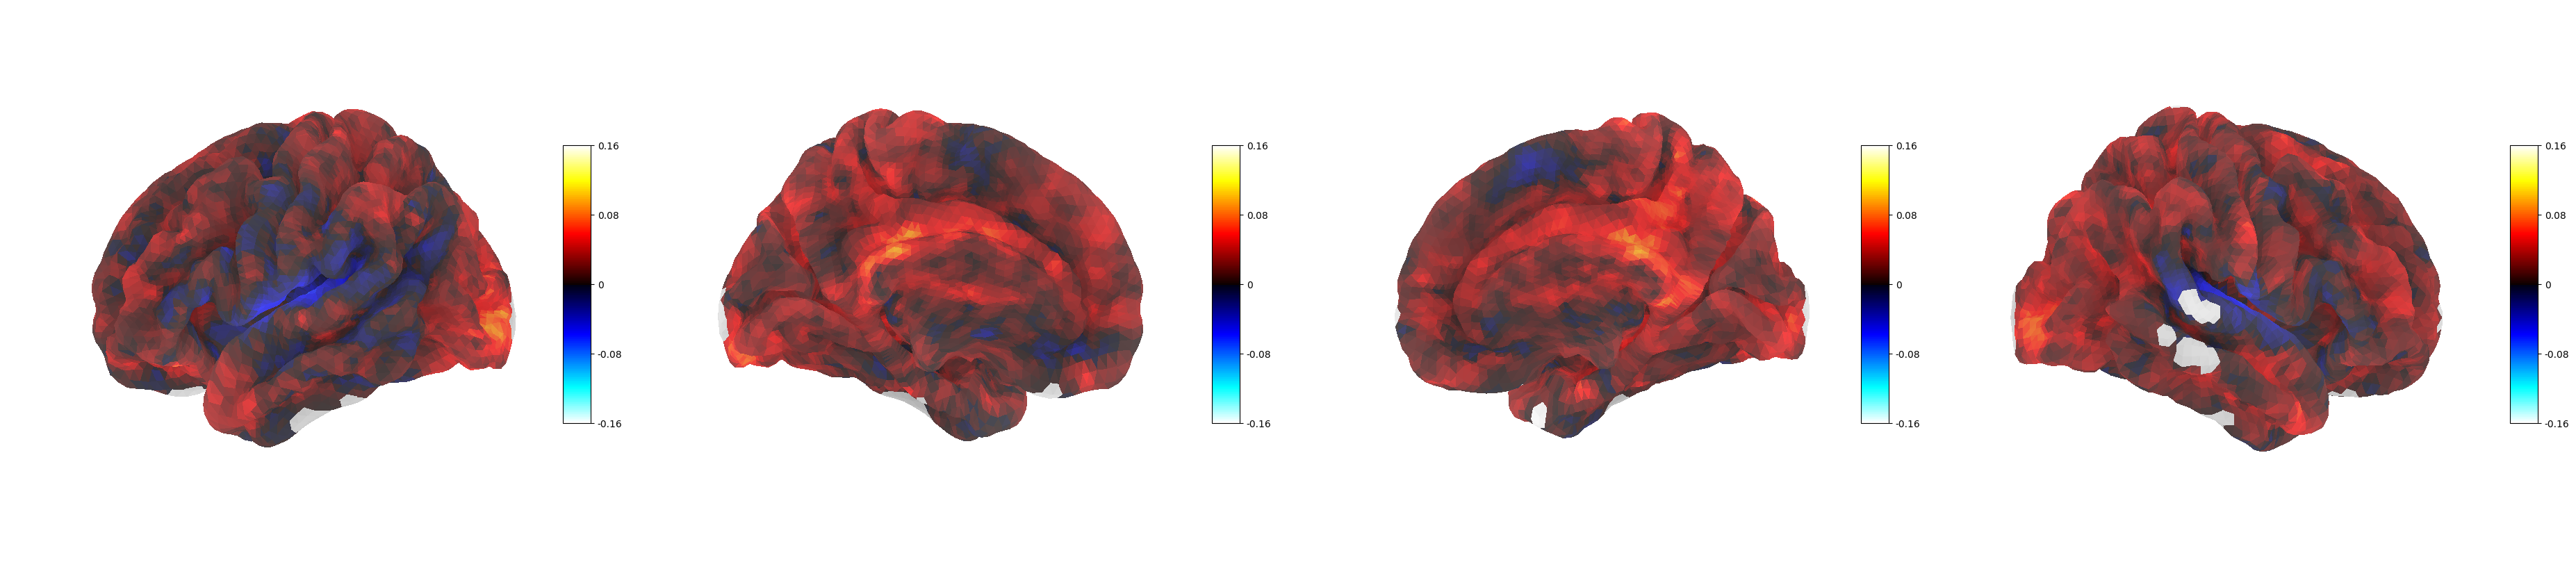

In [52]:
pretty_plot(
    imgs_plot, 
    None,
    None,
    [""],
    ref_img=None,
    vmax=[vmax], 
    cmap='cold_hot',
    hemispheres=['left', 'right'], 
    views=['lateral', 'medial'],
    colorbar=True,
    symmetric_cbar=symmetric_cbar,
    categorical_values=None, 
    inflated=False, 
    saving_folder='fmri_encoder/', 
    format_figure='png', 
    dpi=300, 
    plot_name=plot_name,
    row_size_factor=8,          # you can play with these arguments to modify the shape of the brain vertically
    column_size_factor=12,      # you can play with these arguments to modify the shape of the brain horizontally
    overlapping=4,
)

# Viz design matrix

In [ ]:
output_dicts = {}
for encoding_method in ["hrf", "fir"]:
    output_dicts[encoding_method] = default_processing(X=X[:1], Y=Y[:1], offsets=offsets[:1], durations=durations[:1], tr=2, masker_path=masker_path(), encoding_method=encoding_method)

In [ ]:
vizs = []
e = events[0][features[:6] + ["time", "word"]]
for encoding_method, output_dict in output_dicts.items():
    if encoding_method == "fir":
        viz = pd.DataFrame(output_dict["X"][0][:, :30])
    else:
        viz = pd.DataFrame(output_dict["X"][0][:, :6])
    viz["time"] = 2 * viz.index  + 2
    viz = viz.set_index("time").T
    if encoding_method == "fir":
        viz["Reg"] = np.concatenate([[f] * 5 for f in features[:6]])
        viz["Delay"] = np.concatenate([list(range(1, 6))] * (viz.shape[0] // 5))
    else:
        viz["Reg"] = features[:6]
        viz["Delay"] = 0
    viz = viz.melt(id_vars=["Reg", "Delay"])
    viz["time"] = viz.time.astype(float)
    viz["encoding_method"] = encoding_method
    viz = pd.merge_asof(viz, e[["time", "word"]].dropna(), on="time", direction="nearest")
    vizs.append(viz)
e = e.melt(id_vars=["time", "word"], var_name="Reg").assign(encoding_method="raw", Delay=0)
vizs.append(e)
vizs = pd.concat(vizs).query("time < 20")
vizs["word"] = vizs.word.fillna("")
vizs = vizs.fillna(0)

In [ ]:
fig = px.line(vizs, x="time", y="value", color="Delay", facet_col="Reg", facet_row="encoding_method", hover_data=["word"])
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.write_html(f"fmri_encoder/figures/viz_design_matrices.html")
fig.update_yaxes(matches=None)
fig